In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical 
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix,recall_score,precision_score,log_loss,f1_score,roc_auc_score,classification_report
from warnings import filterwarnings
from sklearn.decomposition import PCA
import lightgbm as lgb
import tensorflow as tf
filterwarnings("ignore")
plt.style.use('ggplot')

In [10]:
X_train = pd.read_csv("X_train_df")
X_test = pd.read_csv("X_test_df")
y_train = pd.read_csv("y_train_series")
y_test = pd.read_csv("y_test_series")

In [11]:
X_train = X_train.drop('Unnamed: 0',axis=1).values
X_test = X_test.drop('Unnamed: 0',axis=1).values
y_train = y_train.drop('Unnamed: 0',axis=1).values.reshape(-1,1)
y_test = y_test.drop('Unnamed: 0',axis=1).values.reshape(-1,1)

In [67]:
def get_metric(classifier):
    training_pred = classifier.predict(X_train)
    testing_pred = classifier.predict(X_test)
    
    print("The classification report for training is \n")
    print(classification_report(y_train,training_pred),"\n")
    
    print("The classification report for testing is \n")
    print(classification_report(y_test,testing_pred),"\n")
    
    print("The scores are summed up in the dataframe below")
    
    metrics = [roc_auc_score,accuracy_score,recall_score,precision_score,log_loss,f1_score]
    metric_name = ['Roc Auc','Accuracy','Recall','Precision','Log loss','F1 score']
    
    zipped_list = []
    for i in metrics:
        tr = round(i(y_train,training_pred),2)
        ts = round(i(y_test,testing_pred),2)
        zipped_list.append((tr,ts))
    metric_df = pd.DataFrame(zipped_list,index=metric_name,columns=['Train','Test'])    
    true_dict = pd.Series(y_test.flatten()).value_counts().to_dict()
    pred_dict = pd.Series(testing_pred).value_counts().to_dict()

    tmp_df = pd.DataFrame(zip(true_dict.values(),pred_dict.values()),columns = ['Actual','Predicted'],index=pred_dict.keys())
    tmp_df = tmp_df.div(tmp_df.sum(axis=0), axis=1)
    tmp_df.plot(kind='bar', rot=0, xlabel='Response',ylabel='Percentages', figsize=(14, 6))
#    plt.ylim((0, 100))
    
    return metric_df   

## Base RandomForest

In [13]:
rf_clf = RandomForestClassifier(n_jobs=10)
rf_clf.fit(X_train,y_train)

RandomForestClassifier(n_jobs=10)

The classification report for training is 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    267427
           1       1.00      1.00      1.00    267427

    accuracy                           1.00    534854
   macro avg       1.00      1.00      1.00    534854
weighted avg       1.00      1.00      1.00    534854
 

The classification report for testing is 

              precision    recall  f1-score   support

           0       0.90      0.92      0.91     66972
           1       0.34      0.30      0.32      9250

    accuracy                           0.84     76222
   macro avg       0.62      0.61      0.61     76222
weighted avg       0.84      0.84      0.84     76222
 

The scores are summed up in the dataframe below


,Train,Test
Roc Auc,1.0,0.61
Accuracy,1.0,0.84
Recall,1.0,0.30
Precision,1.0,0.34
Log loss,0.0,5.38
F1 score,1.0,0.32


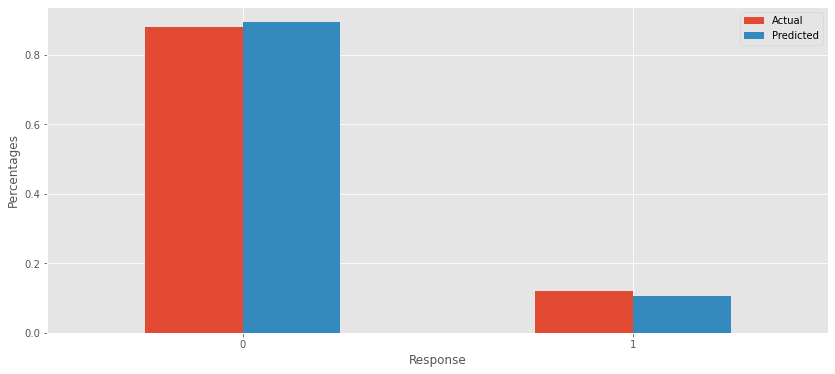

In [14]:
get_metric(rf_clf)

## Gridsearch random forest

In [15]:
cv = RepeatedStratifiedKFold(n_splits=5,n_repeats=2)

In [16]:
rf_param = {'n_estimators' : np.arange(60,120,15),
            'max_depth' : [3, 4, 5],
            'min_samples_leaf' : [1,2,5]
           }

In [17]:
rf_grid = GridSearchCV(estimator=rf_clf,
                       param_grid = rf_param,refit=True,
                       cv = cv, verbose=2, scoring='roc_auc')
rf_grid.fit(X_train,y_train)

Fitting 10 folds for each of 36 candidates, totalling 360 fits
[CV] END ...max_depth=3, min_samples_leaf=1, n_estimators=60; total time=  18.2s
[CV] END ...max_depth=3, min_samples_leaf=1, n_estimators=60; total time=  10.9s
[CV] END ...max_depth=3, min_samples_leaf=1, n_estimators=60; total time=  10.8s
[CV] END ...max_depth=3, min_samples_leaf=1, n_estimators=60; total time=  11.2s
[CV] END ...max_depth=3, min_samples_leaf=1, n_estimators=60; total time=  10.5s
[CV] END ...max_depth=3, min_samples_leaf=1, n_estimators=60; total time=  10.5s
[CV] END ...max_depth=3, min_samples_leaf=1, n_estimators=60; total time=  10.5s
[CV] END ...max_depth=3, min_samples_leaf=1, n_estimators=60; total time=  10.7s
[CV] END ...max_depth=3, min_samples_leaf=1, n_estimators=60; total time=  10.2s
[CV] END ...max_depth=3, min_samples_leaf=1, n_estimators=60; total time=  10.4s
[CV] END ...max_depth=3, min_samples_leaf=1, n_estimators=75; total time=  13.8s
[CV] END ...max_depth=3, min_samples_leaf=1, n

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=5, random_state=None),
             estimator=RandomForestClassifier(n_jobs=10),
             param_grid={'max_depth': [3, 4, 5], 'min_samples_leaf': [1, 2, 5],
                         'n_estimators': array([ 60,  75,  90, 105])},
             scoring='roc_auc', verbose=2)

In [19]:
optimal_rf = rf_grid.best_estimator_

The classification report for training is 

              precision    recall  f1-score   support

           0       0.90      0.68      0.78    267427
           1       0.74      0.93      0.83    267427

    accuracy                           0.80    534854
   macro avg       0.82      0.80      0.80    534854
weighted avg       0.82      0.80      0.80    534854
 

The classification report for testing is 

              precision    recall  f1-score   support

           0       0.98      0.68      0.80     66972
           1       0.28      0.90      0.43      9250

    accuracy                           0.71     76222
   macro avg       0.63      0.79      0.61     76222
weighted avg       0.90      0.71      0.76     76222
 

The scores are summed up in the dataframe below


,Train,Test
Roc Auc,0.80,0.79
Accuracy,0.80,0.71
Recall,0.93,0.90
Precision,0.74,0.28
Log loss,6.78,10.16
F1 score,0.83,0.43


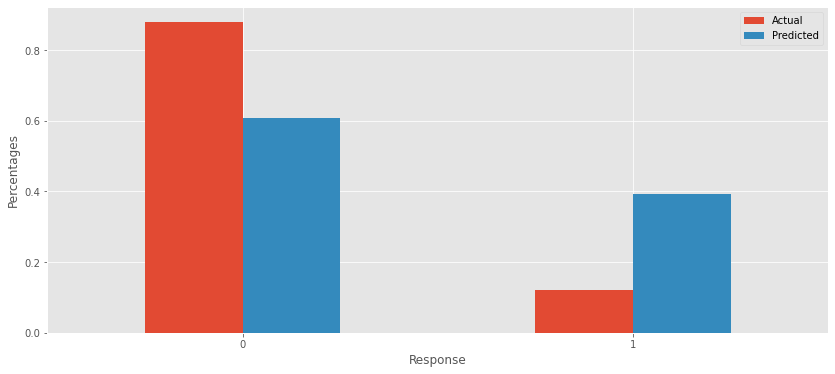

In [80]:
get_metric(optimal_rf)

## Lgbm Classifier

In [30]:
lgbm_clf = lgb.LGBMClassifier()
lgbm_clf.fit(X_train,y_train)

LGBMClassifier()

The classification report for training is 

              precision    recall  f1-score   support

           0       0.89      0.92      0.90    267427
           1       0.91      0.89      0.90    267427

    accuracy                           0.90    534854
   macro avg       0.90      0.90      0.90    534854
weighted avg       0.90      0.90      0.90    534854
 

The classification report for testing is 

              precision    recall  f1-score   support

           0       0.91      0.92      0.91     66972
           1       0.37      0.35      0.36      9250

    accuracy                           0.85     76222
   macro avg       0.64      0.63      0.64     76222
weighted avg       0.84      0.85      0.85     76222
 

The scores are summed up in the dataframe below


,Train,Test
Roc Auc,0.90,0.63
Accuracy,0.90,0.85
Recall,0.89,0.35
Precision,0.91,0.37
Log loss,3.40,5.26
F1 score,0.90,0.36


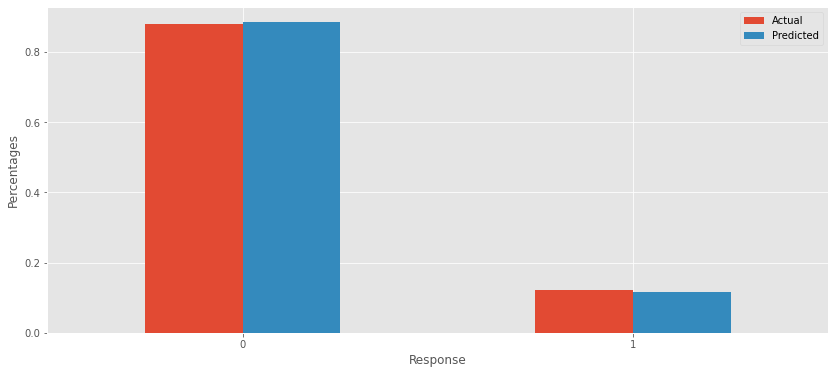

In [81]:
get_metric(lgbm_clf)

In [32]:
lgbm_param =   {'num_leaves': [6, 8, 12, 16],
                'n_estimators': [8, 16, 24],
                'learning_rate': [0.01,0.05],
                }

In [34]:
lgbm_grid = GridSearchCV(estimator=lgbm_clf,
                       param_grid = lgbm_param,refit=True,n_jobs=8,
                       cv = cv, verbose=2, scoring='roc_auc')

In [36]:
lgbm_grid.fit(X_train,y_train)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=5, random_state=None),
             estimator=LGBMClassifier(), n_jobs=8,
             param_grid={'learning_rate': [0.01, 0.05],
                         'n_estimators': [8, 16, 24],
                         'num_leaves': [6, 8, 12, 16]},
             scoring='roc_auc', verbose=2)

In [38]:
optimal_lgbm = lgbm_grid.best_estimator_

The classification report for training is 

              precision    recall  f1-score   support

           0       0.91      0.70      0.79    267427
           1       0.76      0.93      0.84    267427

    accuracy                           0.82    534854
   macro avg       0.84      0.82      0.82    534854
weighted avg       0.84      0.82      0.82    534854
 

The classification report for testing is 

              precision    recall  f1-score   support

           0       0.97      0.70      0.82     66972
           1       0.28      0.85      0.42      9250

    accuracy                           0.72     76222
   macro avg       0.63      0.78      0.62     76222
weighted avg       0.89      0.72      0.77     76222
 

The scores are summed up in the dataframe below


,Train,Test
Roc Auc,0.82,0.78
Accuracy,0.82,0.72
Recall,0.93,0.85
Precision,0.76,0.28
Log loss,6.29,9.65
F1 score,0.84,0.42


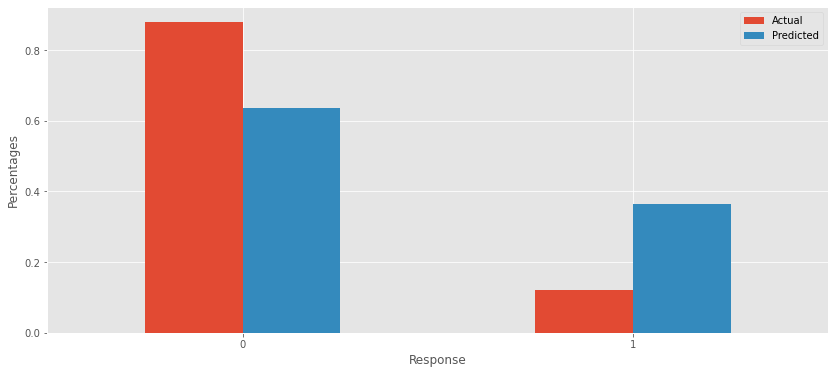

In [82]:
get_metric(optimal_lgbm)

## Neural network

In [52]:
X_train_nn, X_val, y_train_nn, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=0)

In [53]:
Y_train_binary = y_train_nn.copy()
Y_val_binary = y_val.copy()
Y_test_binary = y_test.copy()

Y_train_binary[Y_train_binary > 0] = 1
Y_test_binary[Y_test_binary > 0] = 1


In [72]:
input_size = 12
output_size = 1
hidden_size = 20
model = tf.keras.Sequential([
                             tf.keras.layers.Dense(hidden_size,'relu'),
                             tf.keras.layers.Dropout(0.25),
                             tf.keras.layers.Dense(hidden_size,'relu'),
                             tf.keras.layers.Dropout(0.25),
                             tf.keras.layers.Dense(output_size,'sigmoid')
                            ])
auc_met = tf.keras.metrics.AUC()
adm = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=adm,loss='binary_crossentropy',metrics=[auc_met])

early_stopping = tf.keras.callbacks.EarlyStopping(patience = 2)

In [73]:
model.fit(X_train_nn, Y_train_binary, validation_data=(X_val,Y_val_binary),epochs=50, batch_size=50,verbose = 2,callbacks = [early_stopping])

Epoch 1/50
8558/8558 - 14s - loss: 0.4458 - auc_3: 0.8333 - val_loss: 0.4263 - val_auc_3: 0.8490 - 14s/epoch - 2ms/step
Epoch 2/50
8558/8558 - 12s - loss: 0.4320 - auc_3: 0.8435 - val_loss: 0.4236 - val_auc_3: 0.8530 - 12s/epoch - 1ms/step
Epoch 3/50
8558/8558 - 12s - loss: 0.4304 - auc_3: 0.8463 - val_loss: 0.4230 - val_auc_3: 0.8534 - 12s/epoch - 1ms/step
Epoch 4/50
8558/8558 - 12s - loss: 0.4293 - auc_3: 0.8473 - val_loss: 0.4218 - val_auc_3: 0.8542 - 12s/epoch - 1ms/step
Epoch 5/50
8558/8558 - 12s - loss: 0.4287 - auc_3: 0.8483 - val_loss: 0.4219 - val_auc_3: 0.8538 - 12s/epoch - 1ms/step
Epoch 6/50
8558/8558 - 12s - loss: 0.4286 - auc_3: 0.8483 - val_loss: 0.4211 - val_auc_3: 0.8548 - 12s/epoch - 1ms/step
Epoch 7/50
8558/8558 - 12s - loss: 0.4281 - auc_3: 0.8492 - val_loss: 0.4220 - val_auc_3: 0.8551 - 12s/epoch - 1ms/step
Epoch 8/50
8558/8558 - 12s - loss: 0.4279 - auc_3: 0.8497 - val_loss: 0.4201 - val_auc_3: 0.8560 - 12s/epoch - 1ms/step
Epoch 9/50
8558/8558 - 12s - loss: 0.427

In [84]:
roc_auc_score(y_test,np.round(model.predict(X_test)).astype(int))

0.7953895633673451

## VotingClassifier

In [91]:
vot_clf = VotingClassifier(estimators=[('rf', optimal_rf), ('lgbm', optimal_lgbm)], voting='soft')

In [92]:
vot_clf.fit(X_train,y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=5,
                                                     min_samples_leaf=2,
                                                     n_estimators=105,
                                                     n_jobs=10)),
                             ('lgbm',
                              LGBMClassifier(learning_rate=0.05,
                                             n_estimators=24, num_leaves=16))],
                 voting='soft')

The classification report for training is 

              precision    recall  f1-score   support

           0       0.93      0.67      0.78    267427
           1       0.74      0.95      0.83    267427

    accuracy                           0.81    534854
   macro avg       0.84      0.81      0.81    534854
weighted avg       0.84      0.81      0.81    534854
 

The classification report for testing is 

              precision    recall  f1-score   support

           0       0.98      0.67      0.80     66972
           1       0.28      0.92      0.43      9250

    accuracy                           0.70     76222
   macro avg       0.63      0.79      0.61     76222
weighted avg       0.90      0.70      0.75     76222
 

The scores are summed up in the dataframe below


,Train,Test
Roc Auc,0.81,0.79
Accuracy,0.81,0.70
Recall,0.95,0.92
Precision,0.74,0.28
Log loss,6.57,10.38
F1 score,0.83,0.43


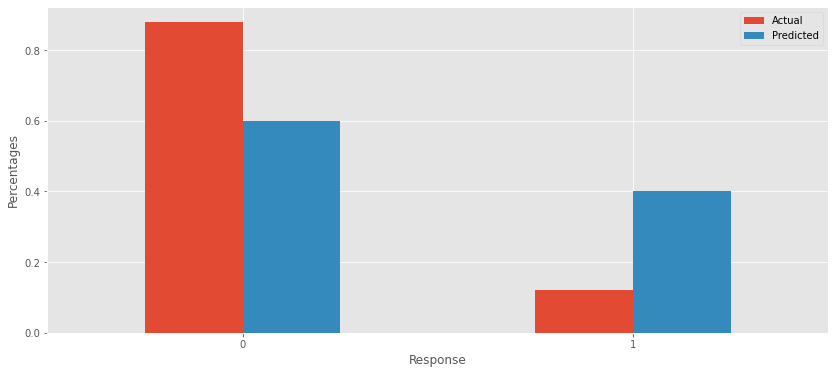

In [93]:
get_metric(vot_clf)

In [94]:
import pickle

In [95]:
pickle.dump(optimal_rf,open('rf.pkl','wb'))

In [96]:
pickle.dump(optimal_lgbm,open('lgbm.pkl','wb'))

In [97]:
pickle.dump(vot_clf,open('vote_clf.pkl','wb'))